# ベイズ最適化

## 0.設定

In [30]:
using Plots
using LinearAlgebra
using LaTeXStrings
using Random
using Distributions
# using SpecialFunctions
using Plots.PlotMeasures; px

0.254mm

In [5]:
# 現在(2021/12/02) inv()でstack overflow が発生するので暫定対処
# 環境：Julia V1.6.4
BLAS.set_num_threads(1)

In [6]:
#シード固定とプログラムで使う型を決める
rng = MersenneTwister(20220105)
FT = Float32

Float32

## 1.問題設定

予測する関数を設定

ガウス関数2つの重ね合わせ
$$
f(x) = a_1 \exp \left[ -\frac{(x-\mu_1)^2}{2\sigma_1^2} \right] + a_2 \exp \left[ -\frac{(x-\mu_2)^2}{2\sigma_2^2} \right]
$$

In [3]:
function exact(x, a₁=0.4, a₂=2.0, μ₁=0.3, μ₂=-0.6, σ₁=0.5, σ₂=0.2)
    ϕ = a₁ .* exp.(-(x .-μ₁).^2 ./(2*σ₁^2)) + a₂ .* exp.(-(x .- μ₂).^2 ./(2*σ₂^2))
end

exact (generic function with 7 methods)

In [17]:
function make_data(FT=Float32; N=30, σₜ = 0.05, lₓ = 1)
    @eval N = $(N)
    @eval σₜ = $(σₜ)
    @eval lₓ = $(lₓ)
    # x_data: [-lₓ, lₓ)の一様分布
    # t_data: exact + 平均0, 標準偏差σₜの正規分布
    @eval x_data = Vector{$(FT)}((rand(rng, $(FT), N) .-0.5) .*(2*lₓ))
    @eval t_data = Vector{$(FT)}(exact.(x_data) .+ randn(rng, $(FT), N) .*σₜ)
    @eval x_dense = Vector{$(FT)}([i for i=-lₓ:2lₓ/50:lₓ])
    @eval t_dense = exact.(x_dense)
end

make_data (generic function with 2 methods)

上記の関数について、ガウス過程の事後確率分布を使用し、獲得関数を評価し、ベイズ最適化を実行する。

## 2.ベイズ最適化の実装

ガウス過程

In [7]:

"""
theta3 = β⁻¹ : 共分散行列のノイズ
"""
function gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
    # repeat(x_data, 1, size(t_data)[1]) - repeat(t_data', size(x_data)[1])
    # .でキャスト、'で転置。Vector{N} - Matrix{1×M} = Matrix{N×M}
    x_diff = x1 .- x2' 
    @assert size(x_diff) == (size(x1)[1], size(x2)[1])
    kmat = θ₁ .* exp.(-(x_diff.^2) ./ θ₂) #アダマール積＆要素ごとのexp
    if x1==x2
        kmat += θ₃*I
    end
    return kmat
end

"""
 x: D次元空間
xtrain = Xₙ : x内のn個の測定点 Vector{n}
ytrain = tₙ : Xₙにおける測定値 Matrix{1×n}
xtest =  xₙ₊₁: 新しい測定点xₙ₊₁ Real or Vector{m}
K = Cₙ : 共分散行列 Matrix{n×n}
k_test = k : xₙとxₙ₊₁の相関? Vector{n} or Matrix{n×m}
k_diag = c : Real or 
"""
function gauss_process(Xₙ, tₙ, xₙ₊₁, func_kernel)
    # @show size(Xₙ)
    Cₙ⁻¹ = inv(func_kernel(Xₙ, Xₙ))
    k = func_kernel(Xₙ, xₙ₊₁)
    c = func_kernel(xₙ₊₁, xₙ₊₁)
    μ = k' * Cₙ⁻¹ * tₙ
    σ² = diag(c - k' * Cₙ⁻¹ * k).^0.5
    return μ, σ²
end

gauss_process

PI, EI用の標準正規分布の累積密度関数

In [9]:
# 誤差関数を使用した実装とパッケージ使用
# 標準正規分布の確率密度関数
normpdf(x) = 1 / sqrt(2pi) * exp(-x*x/2)
# 標準正規分布の累積密度関数
normcdf(x) = (1 + erf(x/sqrt(2))) / 2

normcdf (generic function with 1 method)

改善確率

In [10]:
# Probability of Improvement
function calcPI(tₙ, μₘ, σₘ)
    tmax = maximum(tₙ)
    τ = (μₘ .- tmax)./σₘ
    normcdf.(τ)    
end

calcPI (generic function with 1 method)

期待改善度

In [11]:
# Expected Improvement
function calcEI(tₙ, μₘ, σₘ)
    tmax = maximum(tₙ)
    τ = (μₘ .- tmax)./σₘ
    σₘ .* (τ .*normcdf.(τ) + normpdf.(τ))
end

calcEI (generic function with 1 method)

上側信頼限界

In [13]:
# Upper Confidence Bound
function calcUCB(tₙ, μₘ, σₘ, βₙ=(log(N)/N)^0.5)
    @show N, βₙ
    μₘ .+ βₙ.*σₘ
end
# TODO: Nの挙動が心配なので直す

calcUCB (generic function with 2 methods)

トンプソンサンプリング

In [14]:
# トンプソンサンプリング用のガウス関数基底
function bases_gaussian(x, xmin, xmax, n, σ)
    # base_num * data_num
    μ = range(xmin, xmax, length=n)
    exp.(-(x' .- μ).^2 ./2 ./σ^2)
end
# 最大値、最小値を変えるよう気を付ける
bases_gaussian5(x) = bases_gaussian(x, -1, 1, 5, 0.15)
bases_gaussian10(x) = bases_gaussian(x, -1, 1, 10, 0.15)

bases_gaussian10 (generic function with 1 method)

In [142]:
# Thompson Sampling
# TODO: どこがXₙでどこをX_denseにするのか
#↑新しい点を探すには、最後をX_denseにするこれでよさそう？
function calcTS(Xₙ, tₙ, μₘ, σₘ, X_dense, basefanc)
    Φ = basefanc(Xₙ)
    σ² = σₘ'* σₘ
    A⁻¹ = inv((Φ * Φ')./σ² + I)
    μ2 = A⁻¹*Φ*tₙ ./σ²
    Σ2 = Matrix(Hermitian(A⁻¹)) #A⁻¹のままだと対称行列になっていないかもしれないので、一回変換している
    mvnormal = MvNormal(μ2, Σ2) #多次元正規分布
    w_sample = rand(mvnormal)   #多次元正規分布からサンプリング
    # shapeが(1, num)となり、
    # (w_sample' * bases_gaussian10(X_dense))'としないといけなくなるので少し変えている↓
    basefanc(X_dense)' * w_sample
end
# 参考 https://issp-center-dev.github.io/PHYSBO/manual/master/ja/algorithm.html
# Aを使わない実装
# invps = inv(Φ * Φ' - σ²*I)
# μ = invps *Φ * t_data
# Σ = σ² * invps
# Σ = Matrix(Hermitian(Σ))
# # MvNormal(μ, Σ) 半正定値行列にならず、エラー?

calcTS (generic function with 1 method)

試す

In [35]:
function myplot(x_data, t_data, x_dense, μₘ, σₘ, label=""; dpi=20)
    param = Dict(:dpi=>dpi, :legend=>:bottomleft, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    plt = scatter(x_data, t_data, label="data $(label)", shape=:+, markercolor=:deepskyblue; param...)
    plot!(exact, linecolor=:lime, label="model(unknown)")
    plot!(x_dense, μₘ, ribbon=σₘ, label="predict", fillalpha=0.1, color=:tomato) 
    return plt
end

myplot (generic function with 2 methods)

In [45]:
function myplotAcq(x_dense, α, label=""; dpi=20)
    param = Dict(:dpi=>dpi, :legend=>:topright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    plt = plot(x_dense, α, label=label;param...);
    return plt
end

myplotAcq (generic function with 4 methods)

In [170]:
function myplotAcqAll(x_dense, αPI, αEI, αUCB, αTS5, αTS10, label=""; dpi=20)
    param = Dict(:dpi=>dpi, :legend=>:topright, :xlabel=>L"x", :ylabel=>L"t", :xlim=>(-1, 1))
    plt = plot(x_dense, αPI, label="PI";param...);
    plot!(x_dense, αEI, label="EI");
    plot!(x_dense, αUCB, label="UCB");
#     plot!(x_dense, αTS5, label="TS5");
    plot!(x_dense, αTS10, label="TS10");
    return plt
end

myplotAcqAll (generic function with 2 methods)

In [171]:
function myplots(plts; figsize=(1000, 1000), dpi=20)
    plot(plts..., layout=(size(plts)[1], 1), size=figsize, dpi=dpi)
end

myplots (generic function with 1 method)

In [179]:
make_data(FT);

In [186]:
θ₁, θ₂, θ₃ = [10, 0.03, 0.01]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
σₘ = σₘ² .^0.5
bases_gaussian10(x) = bases_gaussian(x, -1, 1, 10, 0.15)

αPI = calcPI(t_data, μₘ, σₘ)
αEI = calcEI(t_data, μₘ, σₘ)
αUCB = calcUCB(t_data, μₘ, σₘ)
αTS5 = calcTS(x_data, t_data, μₘ, σₘ, x_dense, bases_gaussian5)
αTS10 = calcTS(x_data, t_data, μₘ, σₘ, x_dense, bases_gaussian10);

(N, βₙ) = (30, 0.3367094386194203)


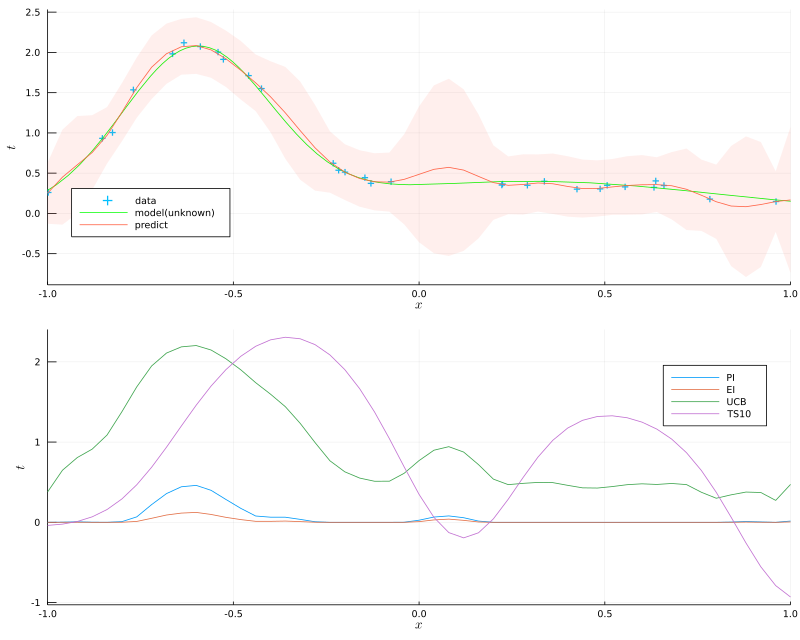

In [187]:
plt1 = myplot(x_data, t_data, x_dense, μₘ, σₘ)
# plot!(x_dense, αTS10);

plt2 = myplotAcqAll(x_dense, αPI, αEI, αUCB, αTS5, αTS10)
plts = [plt1, plt2]
myplots(plts,figsize=(1000, 800))

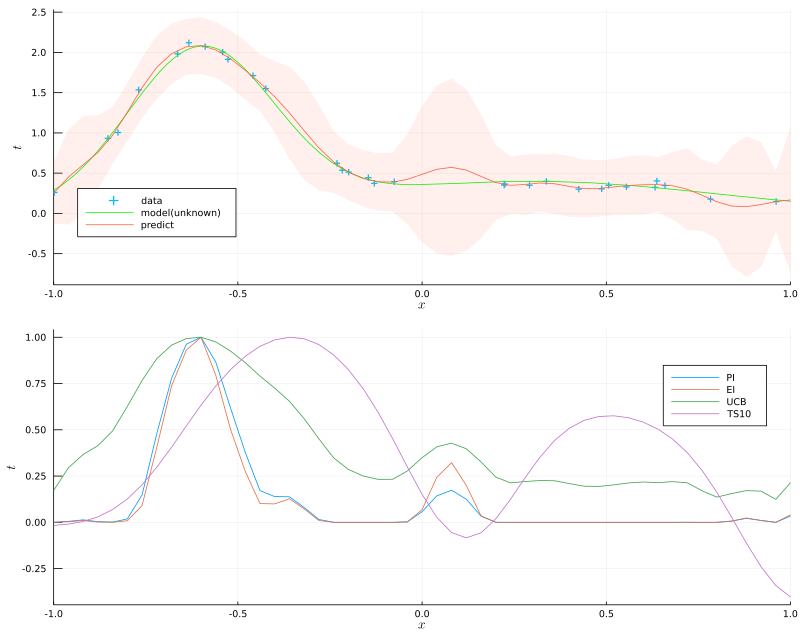

In [188]:
αPI = αPI./maximum(αPI)
αEI = αEI./maximum(αEI)
αUCB = αUCB./maximum(αUCB)
αTS5 = αTS5./maximum(αTS5)
αTS10= αTS10./maximum(αTS10)

plt1 = myplot(x_data, t_data, x_dense, μₘ, σₘ)
# plot!(x_dense, αTS10);

plt2 = myplotAcqAll(x_dense, αPI, αEI, αUCB, αTS5, αTS10)
plts = [plt1, plt2]
myplots(plts,figsize=(1000, 800))

In [205]:
θ₁, θ₂, θ₃ = [10, 0.03, 0.01]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
σₘ = σₘ² .^0.5
bases_gaussian10(x) = bases_gaussian(x, -1, 1, 10, 0.15)

TSS = [calcTS(x_data, t_data, μₘ, σₘ, x_dense, bases_gaussian10) for i=1:10];

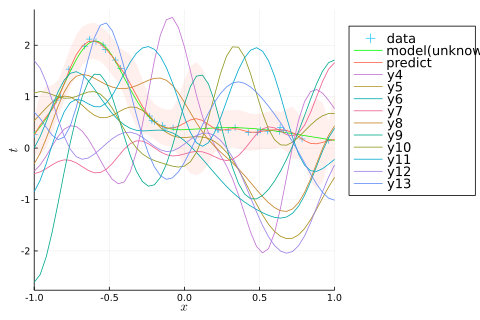

In [206]:
plt1 = myplot(x_data, t_data, x_dense, μₘ, σₘ)
for i=1:10
   plot!(x_dense, TSS[i])
end
plot(plt1, legend=:outertopright)

## 3.サンプル　測定点の自動選択

### PI

┌ Info: Saved animation to 
│   fn = C:\Users\kohei\OneDrive\講義\M1-2 秋\現代物理学\code\report_7.gif
└ @ Plots C:\Users\kohei\.julia\packages\Plots\8GUYs\src\animation.jl:102


Plots.AnimatedGif("C:\\Users\\kohei\\OneDrive\\講義\\M1-2 秋\\現代物理学\\code\\report_7.gif")
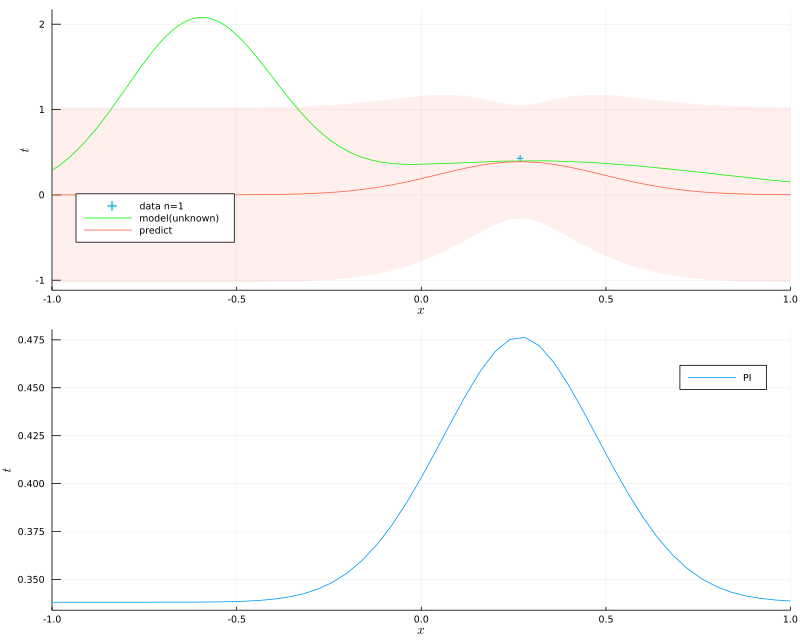

In [102]:
# plts = []
# pltflg = [10, 20, 30]
x_data = Vector{FT}((rand(rng, FT, 1) .-0.5) .*(2*lₓ))
t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, 1) .*σₜ)
x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
t_dense = exact.(x_dense)
θ₁, θ₂, θ₃ = [1, 0.1, 0.1]
# θ₁, θ₂, θ₃ = [1000, 0.03, 0.0001]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)

anim = @animate for i in 1:1:30
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    α = calcPI(t_data, μₘ, σₘ)
    val, j = findmax(α) #獲得関数の最大値とそのインデックスを取る
    
    plt1 = myplot(x_data, t_data, x_dense, μₘ, σₘ, "n=$(i)");
    plt2 = myplotAcq(x_dense, α, "PI");
    plt = myplots([plt1, plt2], figsize=(1000, 800), dpi=80)
#     if i in pltflg
#        push!(plts, plt) 
#     end
    push!(x_data, x_dense[j]) #xdenseとαは同じ大きさなので、そのままjを使える
    push!(t_data, exact(x_data[end]) + σₜ*randn(rng, FT))
end


gif(anim, "report_7.gif", fps=1)

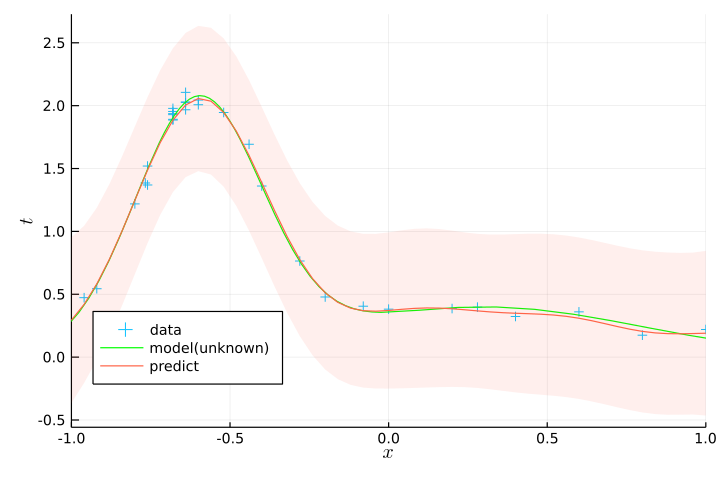

In [101]:
θ₁, θ₂, θ₃ = [1, 0.1, 0.1]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)
μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
σₘ = σₘ² .^0.5
myplot(x_data, t_data, x_dense, μₘ, σₘ, dpi=30)

### EI

┌ Info: Saved animation to 
│   fn = C:\Users\kohei\OneDrive\講義\M1-2 秋\現代物理学\code\report_7.gif
└ @ Plots C:\Users\kohei\.julia\packages\Plots\8GUYs\src\animation.jl:102


Plots.AnimatedGif("C:\\Users\\kohei\\OneDrive\\講義\\M1-2 秋\\現代物理学\\code\\report_7.gif")
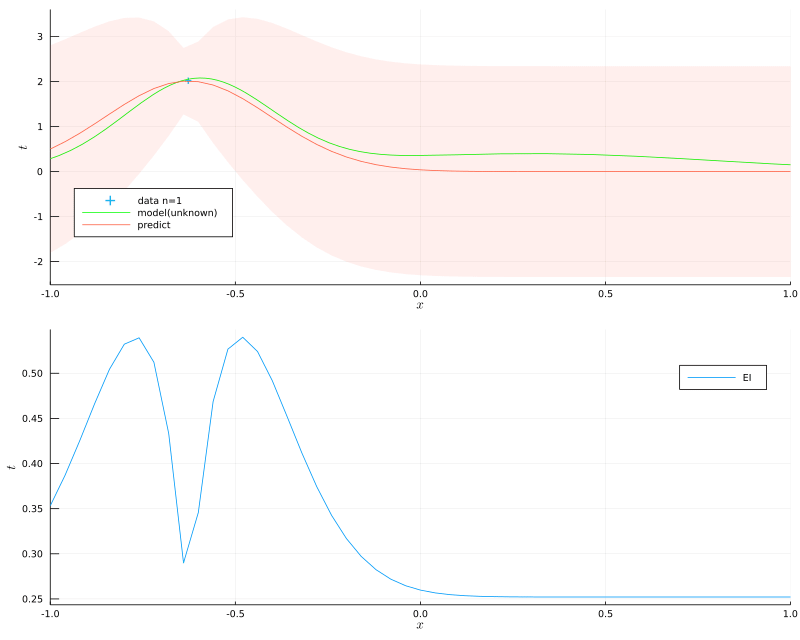

In [128]:
# plts = []
# pltflg = [10, 20, 30]
x_data = Vector{FT}((rand(rng, FT, 1) .-0.5) .*(2*lₓ))
t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, 1) .*σₜ)
x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
t_dense = exact.(x_dense)
# θ₁, θ₂, θ₃ = [1, 0.1, 0.1]
θ₁, θ₂, θ₃ = [30, 0.1, 0.1]
# θ₁, θ₂, θ₃ = [1000, 0.03, 0.0001]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)

anim = @animate for i in 1:1:30
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    α = calcEI(t_data, μₘ, σₘ)
    val, j = findmax(α) #獲得関数の最大値とそのインデックスを取る
    
    plt1 = myplot(x_data, t_data, x_dense, μₘ, σₘ, "n=$(i)");
    plt2 = myplotAcq(x_dense, α, "EI");
    plt = myplots([plt1, plt2], figsize=(1000, 800), dpi=80)
#     if i in pltflg
#        push!(plts, plt) 
#     end
    push!(x_data, x_dense[j]) #xdenseとαは同じ大きさなので、そのままjを使える
    push!(t_data, exact(x_data[end]) + σₜ*randn(rng, FT))
end


gif(anim, "report_7.gif", fps=1)

### UCB

(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)
(N, βₙ) = (30, 5)


┌ Info: Saved animation to 
│   fn = C:\Users\kohei\OneDrive\講義\M1-2 秋\現代物理学\code\report_7.gif
└ @ Plots C:\Users\kohei\.julia\packages\Plots\8GUYs\src\animation.jl:102


Plots.AnimatedGif("C:\\Users\\kohei\\OneDrive\\講義\\M1-2 秋\\現代物理学\\code\\report_7.gif")
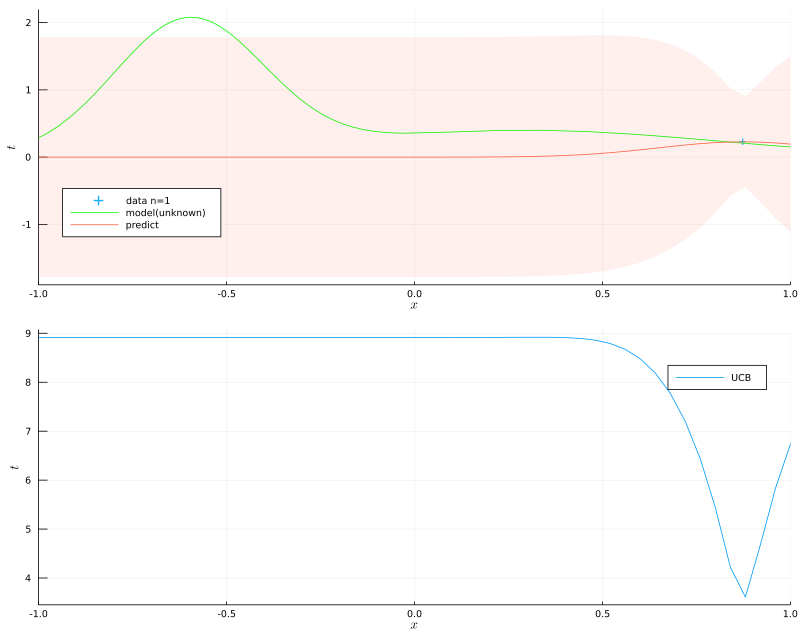

In [214]:
# plts = []
# pltflg = [10, 20, 30]
x_data = Vector{FT}((rand(rng, FT, 1) .-0.5) .*(2*lₓ))
t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, 1) .*σₜ)
x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
t_dense = exact.(x_dense)
# θ₁, θ₂, θ₃ = [1, 0.1, 0.1]
θ₁, θ₂, θ₃ = [10, 0.1, 0.1]
# θ₁, θ₂, θ₃ = [1000, 0.03, 0.0001]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)

anim = @animate for i in 1:1:30
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    α = calcUCB(t_data, μₘ, σₘ, 5)    
#     α = calcUCB(t_data, μₘ, σₘ, (log(i)/i)^0.5)

    val, j = findmax(α) #獲得関数の最大値とそのインデックスを取る
    
    plt1 = myplot(x_data, t_data, x_dense, μₘ, σₘ, "n=$(i)");
    plt2 = myplotAcq(x_dense, α, "UCB");
    plt = myplots([plt1, plt2], figsize=(1000, 800), dpi=80)
#     if i in pltflg
#        push!(plts, plt) 
#     end
    push!(x_data, x_dense[j]) #xdenseとαは同じ大きさなので、そのままjを使える
    push!(t_data, exact(x_data[end]) + σₜ*randn(rng, FT))
end


gif(anim, "report_7.gif", fps=1)

### TS

In [207]:
bases_gaussian10(x) = bases_gaussian(x, -1, 1, 10, 0.15)

bases_gaussian10 (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\kohei\OneDrive\講義\M1-2 秋\現代物理学\code\report_7.gif
└ @ Plots C:\Users\kohei\.julia\packages\Plots\8GUYs\src\animation.jl:102


Plots.AnimatedGif("C:\\Users\\kohei\\OneDrive\\講義\\M1-2 秋\\現代物理学\\code\\report_7.gif")
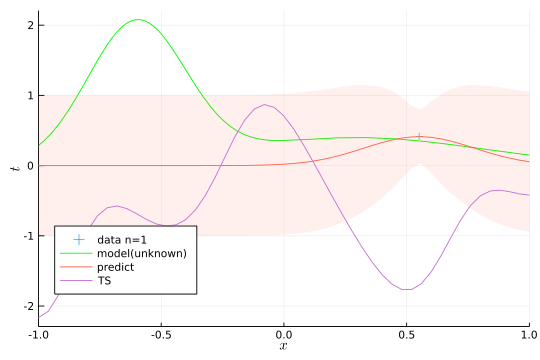

In [211]:
# plts = []
# pltflg = [10, 20, 30]
x_data = Vector{FT}((rand(rng, FT, 1) .-0.5) .*(2*lₓ))
t_data = Vector{FT}(exact.(x_data) .+ randn(rng, FT, 1) .*σₜ)
x_dense = Vector{FT}([i for i=-lₓ:2lₓ/50:lₓ])
t_dense = exact.(x_dense)
# θ₁, θ₂, θ₃ = [1, 0.1, 0.1]
θ₁, θ₂, θ₃ = [1, 0.1, 0.01]
# θ₁, θ₂, θ₃ = [1000, 0.03, 0.0001]
gauss_kernel_param_fixed(x1, x2) = gauss_kernel(x1, x2, θ₁, θ₂, θ₃)

anim = @animate for i in 1:1:30
    μₘ, σₘ² = gauss_process(x_data, t_data, x_dense, gauss_kernel_param_fixed)
    σₘ = σₘ² .^0.5
    α = calcTS(x_data, t_data, μₘ, σₘ, x_dense, bases_gaussian10);

    val, j = findmax(α) #獲得関数の最大値とそのインデックスを取る
    
    plt = myplot(x_data, t_data, x_dense, μₘ, σₘ, "n=$(i)", dpi=90);
    plot!(x_dense, α, label="TS");
#     plt = myplots([plt1, plt2], figsize=(1000, 800), dpi=80)
#     if i in pltflg
#        push!(plts, plt) 
#     end
    push!(x_data, x_dense[j]) #xdenseとαは同じ大きさなので、そのままjを使える
    push!(t_data, exact(x_data[end]) + σₜ*randn(rng, FT))
end


gif(anim, "report_7.gif", fps=1)